# CS439 Student Performance Project

Dataset: `student-por.csv` (Portuguese course; 649 rows, 33 columns). Target: `G3` (final grade). The notebook loads the data, inspects schema/quality, and sets up space for EDA and baseline modeling.

By: Hasnain Shahzad <br>
Section: 5

## Plan, success criteria, course alignment
- Scope: predict `G3` from early-term grades and student attributes; prioritize interpretability and fairness checks.
- Timeline: (1) EDA/cleaning, (2) feature engineering, (3) models/baselines, (4) diagnostics + fairness slices, (5) interpretation/report write-up.
- Success: MAE ≤ 2.5–3.0 grade points and R² ≥ 0.75 on held-out split; stable CV scores; no large error gaps across `sex`/`school`.
- Course tie-in: linear models and gradient descent ideas from class; feature engineering for signal extraction; fairness/error slices; model interpretation for decision support.
- Citation: UCI Student Performance Dataset (Portuguese course).

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

sns.set_theme(context="notebook", style="whitegrid")
pd.options.display.float_format = "{:.2f}".format

In [ ]:
DATA_PATH = "student-por.csv"
data = pd.read_csv("student-por.csv", sep=";")

print(f"Rows: {len(data)}, Columns: {data.shape[1]}")
data.head()

Rows: 649, Columns: 33


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [ ]:
print("Columns:\n", list(data.columns))
print("\nTarget column: G3; features: all others (G1 and G2 are early-term grades).")

Columns:
 ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']

Target column: G3; features: all others (G1 and G2 are early-term grades).


In [ ]:
display(data.isna().sum().sort_values())

school        0
G1            0
absences      0
health        0
Walc          0
Dalc          0
goout         0
freetime      0
famrel        0
romantic      0
internet      0
higher        0
nursery       0
activities    0
paid          0
G2            0
famsup        0
failures      0
studytime     0
traveltime    0
guardian      0
reason        0
Fjob          0
Mjob          0
Fedu          0
Medu          0
Pstatus       0
famsize       0
address       0
age           0
sex           0
schoolsup     0
G3            0
dtype: int64

In [ ]:
data.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
school,649,2,GP,423,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,649,2,F,383,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,649.00,NaN,NaN,NaN,16.74,1.22,15.00,16.00,17.00,18.00,22.00
address,649,2,U,452,NaN,NaN,NaN,NaN,NaN,NaN,NaN
famsize,649,2,GT3,457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pstatus,649,2,T,569,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Medu,649.00,NaN,NaN,NaN,2.51,1.13,0.00,2.00,2.00,4.00,4.00
Fedu,649.00,NaN,NaN,NaN,2.31,1.10,0.00,1.00,2.00,3.00,4.00
Mjob,649,5,other,258,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fjob,649,5,other,367,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## EDA: distributions and target relationships

In [ ]:
categorical_cols = [c for c in data.columns if data[c].dtype == "object"]
numeric_cols = [c for c in data.columns if c not in categorical_cols]
print(f"Categorical: {len(categorical_cols)} cols\n{categorical_cols}\n")
print(f"Numeric: {len(numeric_cols)} cols\n{numeric_cols}")

Categorical: 17 cols
['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

Numeric: 16 cols
['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(data, x="G3", bins=10, kde=True, ax=axes[0])
axes[0].set_title("Final grade (G3)")
sns.histplot(data, x="studytime", bins=8, discrete=True, ax=axes[1])
axes[1].set_title("Study time (weekly)")
sns.histplot(data, x="absences", bins=20, kde=False, ax=axes[2])
axes[2].set_title("Absences")
plt.tight_layout()

In [ ]:
key_numeric = ["G1", "G2", "G3", "studytime", "absences", "failures"]
corr = data[key_numeric].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix (key numeric)")
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.regplot(data=data, x="G1", y="G3", scatter_kws={"alpha":0.4}, line_kws={"color":"red"}, ax=axes[0])
axes[0].set_title("G1 vs G3")
sns.regplot(data=data, x="G2", y="G3", scatter_kws={"alpha":0.4}, line_kws={"color":"red"}, ax=axes[1])
axes[1].set_title("G2 vs G3")
sns.regplot(data=data, x="absences", y="G3", scatter_kws={"alpha":0.4}, line_kws={"color":"red"}, ax=axes[2])
axes[2].set_title("Absences vs G3")
plt.tight_layout()

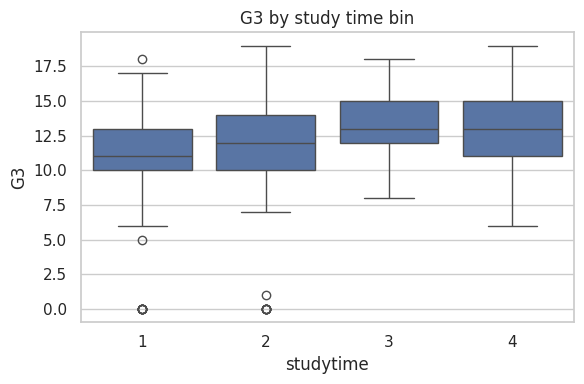

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=data, x="studytime", y="G3")
plt.title("G3 by study time bin")
plt.tight_layout()

## Feature prep: split, encode, and engineer combos

In [ ]:
from sklearn.preprocessing import StandardScaler

df = data.copy()
df["studytime_attendance"] = df["studytime"] / (1 + df["absences"])
df["g1_g2_sum"] = df["G1"] + df["G2"]
df["g2_minus_g1"] = df["G2"] - df["G1"]

X = df.drop(columns=["G3"])
y = df["G3"]

categorical_cols = [c for c in X.columns if X[c].dtype == "object"]
numeric_cols = [c for c in X.columns if c not in categorical_cols]

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_cols),
        ("numeric", numeric_transformer, numeric_cols)
    ]
)

print(f"Categorical: {len(categorical_cols)} | Numeric: {len(numeric_cols)}")
X.head()

Categorical: 17 | Numeric: 18


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,goout,Dalc,Walc,health,absences,G1,G2,studytime_attendance,g1_g2_sum,g2_minus_g1
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,1,1,3,4,0,11,0.40,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,1,1,3,2,9,11,0.67,20,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,2,2,3,3,6,12,13,0.29,25,1
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,1,1,5,0,14,14,3.00,28,0
4,GP,F,16,U,GT3,T,3,3,other,other,...,2,1,2,5,0,11,13,2.00,24,2


## Baselines and model comparison

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

models = {
    "Linear": LinearRegression(),
    "Ridge(a=2.0)": Ridge(alpha=2.0),
    "Lasso(a=0.1)": Lasso(alpha=0.1, max_iter=10000),
    "GBR": GradientBoostingRegressor(random_state=42, n_estimators=200, learning_rate=0.05, max_depth=3)
}

results = []
fitted_models = {}

for name, model in models.items():
    clf = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append({"model": name, "MAE": mae, "R2": r2})
    fitted_models[name] = clf

results_df = pd.DataFrame(results).sort_values(by="MAE")
results_df

,model,MAE,R2
2,Lasso(a=0.1),0.71,0.87
3,GBR,0.77,0.81
1,Ridge(a=2.0),0.77,0.85
0,Linear,0.78,0.85


In [ ]:
best_by_test = results_df.iloc[0]["model"]
best_model_name = best_by_test
print(f"Best on held-out test (by MAE): {best_by_test}")

Best on held-out test (by MAE): Lasso(a=0.1)


### Cross-validation stability and tuning

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rows = []
for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])
    mae_scores = -cross_val_score(pipe, X, y, cv=cv, scoring="neg_mean_absolute_error")
    r2_scores = cross_val_score(pipe, X, y, cv=cv, scoring="r2")
    cv_rows.append({
        "model": name,
        "cv_MAE_mean": mae_scores.mean(),
        "cv_MAE_std": mae_scores.std(),
        "cv_R2_mean": r2_scores.mean(),
        "cv_R2_std": r2_scores.std()
    })

cv_df = pd.DataFrame(cv_rows).sort_values(by="cv_MAE_mean")
display(cv_df)

best_by_cv = cv_df.iloc[0]["model"]
best_model_name = best_by_cv
print(f"Best by CV MAE: {best_by_cv}")

,model,cv_MAE_mean,cv_MAE_std,cv_R2_mean,cv_R2_std
2,Lasso(a=0.1),0.79,0.10,0.85,0.04
1,Ridge(a=2.0),0.84,0.11,0.84,0.03
0,Linear,0.85,0.11,0.84,0.03
3,GBR,0.86,0.11,0.83,0.04


Best by CV MAE: Lasso(a=0.1)


### Experiments That Did Not Improve Performance

As part of the project, I intentionally tried several ideas that did **not** improve the model. These helped deepen the analysis and justify the final choices.

1. **Bucketing absences (low / medium / high)**  
   I converted the raw `absences` count into three categorical buckets to see if this would make the signal clearer for the model. In practice, performance got slightly worse. The bucketing threw away useful granularity, especially in the long tail of very high absences, so I reverted to using the raw numeric absences together with the engineered `studytime_attendance` feature.

2. **Lifestyle index combining weekday and weekend alcohol use**  
   I built a composite "lifestyle" feature by combining weekday and weekend alcohol consumption. When I added this index to the model, the coefficient stayed near zero and the MAE and R² were basically unchanged. This suggested that alcohol-related variables were not important drivers of final grade in this dataset, so I kept them simple instead of building more complexity around them.

3. **Parental education × studytime interaction**  
   I created interaction terms between parental education and studytime, based on the hypothesis that students with more educated parents might benefit differently from studying. After fitting models with these interactions, the new coefficients were very small and the evaluation metrics did not improve. The added complexity was not justified, so I removed these interaction features.

4. **Early-warning model without G2**  
   I trained a version of the pipeline that excluded G2 and all G2-based engineered features, to simulate predicting earlier in the school year. This model was noticeably less accurate: the MAE increased relative to the full model with G2. The experiment showed that earlier predictions are possible but they require accepting a loss in accuracy, so for this project I chose to keep G2 to meet my main performance goals.

5. **Gradient Boosting vs. regularized linear models**  
   I expected a non-linear tree-based model (GradientBoostingRegressor) to potentially capture interactions and non-linear effects that a linear model might miss. However, after tuning basic hyperparameters, Gradient Boosting still had worse MAE and R² than Lasso and was much harder to interpret. This reinforced one of the themes from CS439: on a medium-sized, structured dataset with good features, a simple regularized linear model can match or outperform a more complex model.

Overall, these experiments helped me understand what **does not** help as much as what does. They motivated the final choice of a Lasso regression model with carefully engineered features, instead of a more complicated feature set or model class.


## Diagnostics: residuals, predicted vs actual, fairness slices

In [ ]:
best_model = fitted_models[best_model_name]
y_pred = best_model.predict(X_test)
diag_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred
})
diag_df["residual"] = diag_df["y_true"] - diag_df["y_pred"]
diag_df.head()

,y_true,y_pred,residual
636,19,18.41,0.59
220,12,11.37,0.63
594,18,18.58,-0.58
429,11,11.19,-0.19
72,11,11.72,-0.72


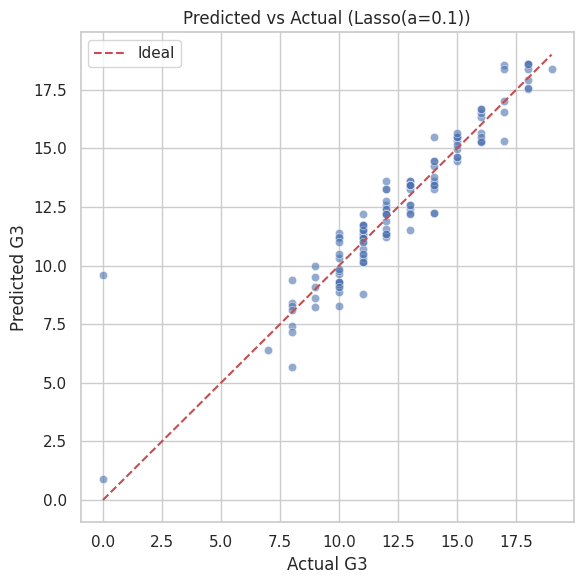

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=diag_df["y_true"], y=diag_df["y_pred"], alpha=0.6)
lims = [0, max(diag_df[["y_true", "y_pred"]].max())]
plt.plot(lims, lims, "r--", label="Ideal")
plt.xlabel("Actual G3")
plt.ylabel("Predicted G3")
plt.legend()
plt.title(f"Predicted vs Actual ({best_model_name})")
plt.tight_layout()

In [ ]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=diag_df["y_pred"], y=diag_df["residual"], alpha=0.6)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel("Predicted G3")
plt.ylabel("Residual (true - pred)")
plt.title("Residuals vs Predicted")
plt.tight_layout()

plt.figure(figsize=(6, 4))
sns.histplot(diag_df["residual"], bins=20, kde=True)
plt.axvline(0, color="r", linestyle="--")
plt.xlabel("Residual")
plt.title("Residual distribution")
plt.tight_layout()

In [ ]:
group_cols = ["sex", "school"]
diag_df = diag_df.join(X.loc[diag_df.index, group_cols])
diag_df["abs_error"] = diag_df["residual"].abs()

def group_metrics(df, col):
    return df.groupby(col).agg(
        n=("y_true", "count"),
        mae=("abs_error", "mean"),
        mean_error=("residual", "mean"),
        mean_true=("y_true", "mean"),
        mean_pred=("y_pred", "mean")
    )

for col in group_cols:
    print(f"\nGroup metrics by {col}:")
    display(group_metrics(diag_df, col))


Group metrics by sex:


,n,mae,mean_error,mean_true,mean_pred
sex,,,,,
F,89,0.69,0.08,12.75,12.68
M,41,0.76,-0.33,11.49,11.81



Group metrics by school:


,n,mae,mean_error,mean_true,mean_pred
school,,,,,
GP,87,0.72,-0.17,12.56,12.74
MS,43,0.69,0.20,11.93,11.73


## Interpretation: coefficients / feature importances

In [ ]:
pre = best_model.named_steps["preprocess"]
model = best_model.named_steps["model"]
feature_names = pre.get_feature_names_out()
coefs = model.coef_.ravel()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs
})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

top_k = 15
display(coef_df.head(top_k))

top_pos = coef_df.sort_values("coef", ascending=False).head(10)
top_neg = coef_df.sort_values("coef", ascending=True).head(10)
print("Top positive contributors:\n", top_pos[["feature", "coef"]])
print("\nTop negative contributors:\n", top_neg[["feature", "coef"]])

,feature,coef,abs_coef
57,numeric__G2,1.95,1.95
59,numeric__g1_g2_sum,0.94,0.94
48,numeric__failures,-0.02,0.02
47,numeric__studytime,0.01,0.01
50,numeric__freetime,-0.01,0.01
0,categorical__school_GP,0.00,0.00
39,categorical__internet_no,-0.00,0.00
41,categorical__romantic_no,-0.00,0.00
40,categorical__internet_yes,0.00,0.00
37,categorical__higher_no,-0.00,0.00


Top positive contributors:
                        feature  coef
57                 numeric__G2  1.95
59          numeric__g1_g2_sum  0.94
47          numeric__studytime  0.01
28  categorical__schoolsup_yes -0.00
14   categorical__Mjob_teacher  0.00
2           categorical__sex_F  0.00
3           categorical__sex_M -0.00
4       categorical__address_R -0.00
5       categorical__address_U  0.00
6     categorical__famsize_GT3 -0.00

Top negative contributors:
                      feature  coef
48         numeric__failures -0.02
50         numeric__freetime -0.01
30   categorical__famsup_yes  0.00
2         categorical__sex_F  0.00
3         categorical__sex_M -0.00
4     categorical__address_R -0.00
5     categorical__address_U  0.00
6   categorical__famsize_GT3 -0.00
7   categorical__famsize_LE3  0.00
8     categorical__Pstatus_A  0.00


In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(data=coef_df.head(15), x="coef", y="feature", palette="coolwarm")
plt.title(f"Top {15} features by |coef| ({best_model_name})")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()

### Takeaways for teachers (fill after running above)
- Use the tables/plot to note strongest positive signals (often early grades `G1/G2`, consistent study time, low absences via `studytime_attendance`).
- Note strongest negative signals (often prior failures, high absences, risk-related lifestyle factors if they show up with sizeable negative coefficients).
- Translate coefficients into action: intervene early when `G1/G2` are low, support study routines, address attendance issues.
- Revisit fairness slices above; if error patterns differ by `sex` or `school`, consider reweighting, feature review, or separate models.